In [755]:
import numpy as np
from numpy.random import uniform
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import sympy as smp
plt.style.use(['science', 'notebook'])

Read in the data

In [2]:
df = pd.read_csv('water_data.txt', sep=' ', dtype=np.float32)
energy_d = df['Energy(MeV)'].values
coherent_d = df['Coherent(cm^2g^-1)'].values
compton_d = df['Compton(cm^2g^-1)'].values
photo_d = df['Photoelectric(cm^2g^-1)'].values
pairtrip_d = df['Pair+Triplet(cm^2g^-1)'].values
Etrans_d = df['Energy-Transfer(cm^2g^-1)'].values
Eabs_d = df['Energy-Absorption(cm^2g^-1)'].values
brem_d = df['1-g'].values
mu_d = coherent_d + compton_d+photo_d + pairtrip_d

In [594]:
energy_d

array([1.00e-03, 1.50e-03, 2.00e-03, 3.00e-03, 4.00e-03, 5.00e-03,
       6.00e-03, 8.00e-03, 1.00e-02, 1.50e-02, 2.00e-02, 3.00e-02,
       4.00e-02, 5.00e-02, 6.00e-02, 8.00e-02, 1.00e-01, 1.50e-01,
       2.00e-01, 3.00e-01, 4.00e-01, 5.00e-01, 6.00e-01, 8.00e-01,
       1.00e+00, 1.25e+00, 1.50e+00, 2.00e+00, 3.00e+00, 4.00e+00,
       5.00e+00, 6.00e+00, 8.00e+00, 1.00e+01, 1.50e+01, 2.00e+01,
       3.00e+01, 4.00e+01, 5.00e+01], dtype=float32)

In [590]:
1/mu_d

array([2.4501496e-04, 7.2923675e-04, 1.6202419e-03, 5.1818918e-03,
       1.2076959e-02, 2.3490721e-02, 4.0526848e-02, 9.6394829e-02,
       1.8775816e-01, 5.9772861e-01, 1.2351779e+00, 2.6602819e+00,
       3.7243948e+00, 4.4130626e+00, 4.8590865e+00, 5.4368510e+00,
       5.8441939e+00, 6.6590748e+00, 7.3164134e+00, 8.4243450e+00,
       9.3997421e+00, 1.0325906e+01, 1.1164740e+01, 1.2707478e+01,
       1.4132283e+01, 1.5808744e+01, 1.7383780e+01, 2.0240391e+01,
       2.5229048e+01, 2.9347950e+01, 3.2957008e+01, 3.6150928e+01,
       4.1133545e+01, 4.5063915e+01, 5.1412987e+01, 5.5004875e+01,
       5.8444992e+01, 5.9594517e+01, 5.9844231e+01], dtype=float32)

Photon Spectrum 6MV

In [399]:
def get_6MV_spectrum(N):
    cdf = np.array([2480,15000,27290,37590,46310,53760,60140,65680,70460,
                       74630,78290, 81510, 84330, 86860, 89090, 91060, 92790,
                       94330, 95670, 96840, 97850, 98710, 99420, 100000]) /100000
    energies = np.arange(0.25, 6.25, 0.25)
    return energies[np.searchsorted(cdf, np.random.rand(N))]

Plots of mass attenuation coefficients and relative probabilities of interactions at different energies.

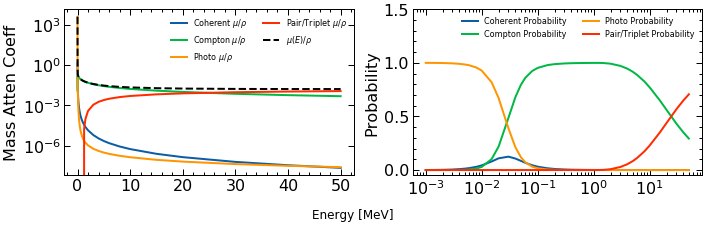

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].plot(energy_d, coherent_d, label=r'Coherent $\mu/\rho$')
ax[0].plot(energy_d, compton_d, label=r'Compton $\mu/\rho$')
ax[0].plot(energy_d, photo_d, label=r'Photo $\mu/\rho$')
ax[0].plot(energy_d, pairtrip_d, label=r'Pair/Triplet $\mu/\rho$')
ax[0].plot(energy_d, mu_d, color='k', ls='--', label=r'$\mu(E)/\rho$')
ax[0].set_ylabel('Mass Atten Coeff')
ax[0].semilogy()
ax[0].legend(fontsize=8, ncol=2)
ax[1].plot(energy_d, coherent_d/mu_d, label=r'Coherent Probability')
ax[1].plot(energy_d, compton_d/mu_d, label=r'Compton Probability')
ax[1].plot(energy_d, photo_d/mu_d, label=r'Photo Probability')
ax[1].plot(energy_d, pairtrip_d/mu_d, label=r'Pair/Triplet Probability')
ax[1].semilogx()
ax[1].legend(fontsize=8, ncol=2)
ax[1].set_ylim(top=1.5)
ax[1].set_ylabel('Probability')
fig.suptitle('Energy [MeV]', y=0)
fig.tight_layout()

Function to get mean path length as a function of energy

In [42]:
mu_f = interp1d(energy_d, mu_d)
prob_coherent_f = interp1d(energy_d, coherent_d/mu_d)
prob_compton_f = interp1d(energy_d, compton_d/mu_d)
prob_photo_f = interp1d(energy_d, photo_d/mu_d)
prob_pairtrip_f = interp1d(energy_d, pairtrip_d/mu_d)                 
def get_interaction_type(E):
    interactions = np.zeros(N, dtype=int)
    probs = np.array([prob_coherent_f(E),
                    prob_photo_f(E),
                    prob_compton_f(E),
                    prob_pairtrip_f(E)]).cumsum(axis=0)
    U = uniform(size=N)
    interactions[U<probs[0]] = 1
    interactions[(U>=probs[0])*(U<probs[1])] = 2
    interactions[(U>=probs[1])*(U<probs[2])] = 3
    interactions[(U>=probs[2])*(U<=probs[3])] = 4
    interactions[E<E_cutoff] = 0
    return interactions

# The Simulation

In [43]:
N = 100000

In [44]:
E_val = 0.03 #MeV
E_cutoff = 10/1000 #MeV (10keV)

In [45]:
U1, U2 = uniform(size=(2,N))
Phi0 = 2*np.pi*U1
Theta0 = np.arccos(1-2*U2)

In [46]:
n = np.array([np.cos(Phi0)*np.sin(Theta0),
              np.sin(Phi0)*np.sin(Theta0),
              np.cos(Theta0)])
r = np.zeros(n.shape)
E = np.ones(n[0].shape) * E_val
M = np.ones(n[0].shape).astype(bool)

In [47]:
L0 = -1/mu_f(E) *np.log(uniform(size=N))

In [48]:
I = get_interaction_type(E)

<BarContainer object of 3 artists>

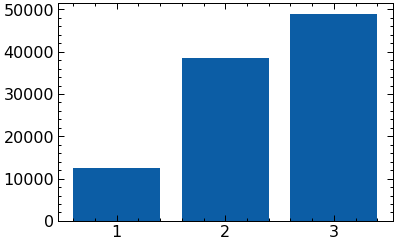

In [49]:
plt.bar(*np.unique(get_interaction_type(E), return_counts=True))

In [22]:
I

array([2, 1, 2, ..., 2, 2, 2])

Sampling Compton distribution

$$\frac{d\sigma}{d\Omega} = \frac{e^4}{m^2}\left(\frac{E'}{E}\right)^2\left(\frac{E}{E'}+\frac{E'}{E}-\sin^2\theta\right)$$

$$\frac{E}{E'} = 1+(E/m)(1-\cos\theta)$$

And from assignment 2

$$\frac{d\sigma}{d\theta} = \int_{0}^{2\pi}  \frac{d\sigma}{d\Omega} \sin\theta d\phi = 2\pi\sin\theta \frac{d\sigma}{d\Omega} $$

In [1057]:
from scipy.stats import rv_continuous
class klein_gen(rv_continuous):
    def __init__(self, m=0.511):
        super(klein_gen, self).__init__()
        self.m = 0.511
    def get_pdf(self, x, E, norm=False):
        ratio = 1+E/self.m * (1-np.cos(x))
        pdf = np.sin(x) * (1/ratio)**2 * (ratio + 1/ratio - np.sin(x)**2)
        if norm:
            return pdf/(sum(pdf)*np.diff(x)[0])
        else:
            return pdf
    def get_rvs(self, E):
        N = len(E)
        finished = np.zeros(N).astype(bool)
        thetas = np.zeros(N)
        while True:
            still_need = ~finished ==True
            n = still_need.sum()
            x = uniform(size=n)*np.pi 
            y = uniform(size=n)*2
            updated_indices = y<self.get_pdf(x, E[still_need])
            updated_thetas = x[updated_indices]
            still_need[still_need] = updated_indices # a trick
            thetas[still_need] = np.copy(updated_thetas)
            finished[still_need] = True
            if finished.all():
                return thetas
    
klein = klein_gen()

In [1065]:
N = 500000
E = get_6MV_spectrum(N)
#E = np.ones(N)*6
thetas = np.linspace(0, np.pi, 100)
pdf = klein.get_pdf(thetas, 6, norm=True)
Theta1_p = klein.get_rvs(E)
Phi1_p = uniform(size=len(E))

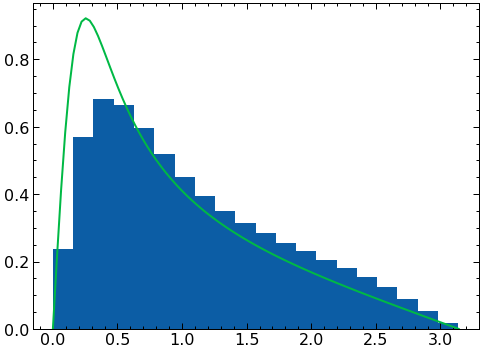

In [1066]:
plt.hist(Theta1_p, density=True, bins=20)
plt.plot(thetas, pdf)

The change in photon direction $\hat{v}$ expressed in terms of the rest frame (unprimed) and the photon reference frame (primed) can be expressed as

$$\hat{v}(\phi', \theta', \phi, \theta) = R_2(\theta) R_1(\phi) \hat{v}'(\phi', \theta') $$

where $\hat{v}(\phi', \theta', \phi, \theta)$  and  $\hat{v}'(\phi', \theta')$ represent the direction vectors of the photon after compton scattering, and $R_1$ and $R_2$ are matrices to transform between the two reference frames. In component notation,

$$\hat{v}(\phi', \theta', \phi, \theta) = \begin{bmatrix} 1&0&0\\0&\cos\theta&-\sin\theta\\ 0&\sin\theta&\cos\theta \end{bmatrix} \begin{bmatrix} \cos\phi&-\sin\phi&0\\\sin\phi&\cos\phi&0\\ 0&0&1 \end{bmatrix} \begin{bmatrix} \sin\theta'\cos\phi'\\\sin\theta'\sin\phi'\\ \cos\theta' \end{bmatrix} $$

In [1230]:
the, phi, the_p, phi_p = smp.symbols(r"\theta \phi \theta' \phi'", positive=True)

u = smp.Matrix([smp.sin(the)*smp.cos(phi), smp.sin(the)*smp.sin(phi), smp.cos(the)])
v = smp.Matrix([smp.sin(the_p)*smp.cos(phi_p), smp.sin(the_p)*smp.sin(phi_p), smp.cos(the_p)])
zhat = u
yhat = smp.Matrix([-u[1], u[0], 0]); yhat = smp.trigsimp(yhat/yhat.norm())
xhat = smp.trigsimp(yhat.cross(zhat))
R = smp.Matrix([[xhat[0], yhat[0], zhat[0]],
               [xhat[1], yhat[1], zhat[1]],
               [xhat[2],yhat[2],zhat[2]]])

So $\hat{v}(\phi', \theta', \phi, \theta)$ is given by

In [1231]:
expr = smp.trigsimp(R@v).simplify()
expr = expr.subs(smp.Abs(smp.sin(the)), smp.sin(the)).simplify()

In [1232]:
expr.subs([(the,smp.pi/4),(phi,0),(the_p,-smp.pi),(phi_p,0)])

Matrix([
[-sqrt(2)/2],
[         0],
[-sqrt(2)/2]])

Write function to compute this given all angular arguments

In [1233]:
get_new_units = smp.lambdify([the,phi,the_p,phi_p], expr)

Get new direction of photon in rest frame after compton scattering given photon decay angle $(\phi', \theta')$ in the photon reference frame

# Compton Scattering Only

Write function

In [32]:
def run_compton_iterations(N, E_val, E_cutoff, m=0.511):
    # Get initial decay angles of all photons
    Phi0 = 2*np.pi*uniform(size=N)
    Theta0 = np.arccos(1-2*uniform(size=N))
    n0 = np.array([np.cos(Phi0)*np.sin(Theta0),
              np.sin(Phi0)*np.sin(Theta0),
              np.cos(Theta0)])
    # Get initial energy, length before decay, and position of all photons
    E = np.ones(N) * E_val #energy
    L = -1/mu_f(E) *np.log(uniform(size=N))
    r = L * n0 
    M = np.ones(N).astype(bool) 
    iteration = 0
    iterations = []
    interactions = []
    # For compton scattering statistics
    all_energies_photon_comp = []
    all_energies_electron_comp = []
    while True:
        # Throughout this, M gives indices of particles that haven't decayed yet
        iterations.append(iteration)
        interactions.append(sum(M))
        Theta_new_p = klein.get_rvs(E[M]) 
        Phi_new_p = 2*np.pi*uniform(size=len(E[M]))
        # Get electron energy from new angles
        T = E[M] - E[M] / (1 + E[M]/m * (1-np.cos(Theta_new_p)))
        all_energies_photon_comp.append(E[M].copy())
        all_energies_electron_comp.append(T.copy()/E[M].copy())
        # Now change the energies
        E[M] = E[M] / (1 + E[M]/m * (1-np.cos(Theta_new_p)))
        L = -1/mu_f(E[M]) *np.log(uniform(size=len(E[M])))
        n = np.squeeze(get_new_units(Theta0[M], Phi0[M], Theta_new_p, Phi_new_p), axis=1)
        # New Directions
        Phi0 = np.arctan(n[1]/n[0])
        Theta0 = np.arctan(np.sqrt(n[0]**2+n[1]**2)/n[2])
        # only consider these points now
        E = E[M]
        M = E>E_cutoff
        iteration +=1
        if np.all(~M):
            return (np.array(iterations), np.array(interactions),
                   np.concatenate(all_energies_photon_comp),
                   np.concatenate(all_energies_electron_comp))

Define parameters for specific energy

In [33]:
N = 100000
m=0.511
E_val = 20
E_cut = 0.01
energy_bins = np.linspace
iterations, interactions, aepc, aeec = run_compton_iterations(N, E_val, E_cut)

Get average energy transferred to electron vs incident photon energy ()through binning

In [34]:
counts, b, c= np.histogram2d(aeec, aepc, bins=100)
counts/=counts.sum(axis=0)
ee_arr = b[:-1] + np.diff(b)/2
ep_arr = c[:-1] + np.diff(c)/2
ee_avg_arr = counts.T@ee_arr

Plot

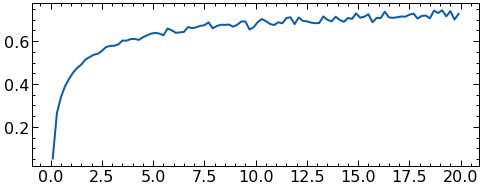

In [35]:
plt.figure(figsize=(8,3))
plt.plot(ep_arr, ee_avg_arr)

From assignment 2 we can predict this curve. Using

$$\left< T/E \right> = \int_{T_{min}}^{T_{max}} \left(\frac{T}{E}\right) f(T;E) dT$$

First we get the the probability density function of kinetic energy transferred to the electron $f(T;E)$ at a certain value of $\alpha=E/m$

In [36]:
E, alpha, T, theta = smp.symbols(r'E \alpha T \theta', real=True, positive=True)
T_expr = E*alpha*(1-smp.cos(theta))/(1+alpha*(1-smp.cos(theta)))
theta_expr = smp.solve(T-T_expr, theta)[1]
dsdo_expr = smp.Rational(1,2)*(1+smp.cos(theta)**2)/(1+alpha*(1-smp.cos(theta)))**2 * \
            ( 1 + alpha**2 * (1-smp.cos(theta))**2 / ((1+smp.cos(theta)**2)*(1+alpha*(1-smp.cos(theta)))))
dsdT = 2*smp.pi*smp.sin(theta) * dsdo_expr / smp.diff(T_expr, theta)
dsdT = dsdT.subs(theta, theta_expr).simplify()
Tmin = 0 
Tmax = 2*E*alpha/(1+2*alpha)
sigma_check = smp.integrate(dsdT, (T, Tmin, Tmax)).expand().simplify().simplify()
pdf = dsdT / sigma_check
pdf

(4*\alpha**2 + 4*\alpha + 1)*(2*E**3*\alpha**2 - 4*E**2*T*\alpha**2 - 2*E**2*T*\alpha + 3*E*T**2*\alpha**2 + 2*E*T**2*\alpha + E*T**2 - T**3*\alpha**2)/(E**2*(E**2 - 2*E*T + T**2)*(2*\alpha**4 + 18*\alpha**3 + 16*\alpha**2 + 4*\alpha + (4*\alpha**4 - 4*\alpha**3 - 15*\alpha**2 - 10*\alpha - 2)*log(2*\alpha + 1)))

Find the average value of $T/E$ (as a function of $\alpha$) using $\left< T/E \right> = \int_{T_{min}}^{T_{max}} \left(\frac{T}{E}\right) f(T;E) dT$

In [37]:
avgT = smp.integrate(pdf*(T/E), (T, Tmin, Tmax)).simplify().simplify()
avgT

(-20*\alpha**5 + 102*\alpha**4 + 186*\alpha**3 + 102*\alpha**2 + 18*\alpha + (24*\alpha**5 - 12*\alpha**4 - 126*\alpha**3 - 141*\alpha**2 - 60*\alpha - 9)*log(2*\alpha + 1))/(3*(4*\alpha**5 + 38*\alpha**4 + 50*\alpha**3 + 24*\alpha**2 + 4*\alpha + (8*\alpha**5 - 4*\alpha**4 - 34*\alpha**3 - 35*\alpha**2 - 14*\alpha - 2)*log(2*\alpha + 1)))

Turn this into numerical function for plotting

In [39]:
avgT_f = smp.lambdify(alpha, avgT)
energy_arr = np.linspace(0.01, E_val, 1000)
avgT_arr = avgT_f(energy_arr/m)

Plot

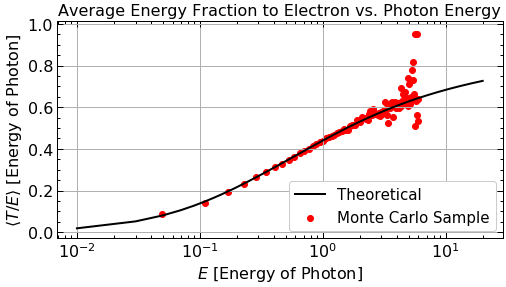

In [598]:
plt.figure(figsize=(8,4))
plt.scatter(ep_arr, ee_avg_arr, color='r', label='Monte Carlo Sample')
plt.plot(energy_arr, avgT_arr, color='k', label='Theoretical')
plt.title('Average Energy Fraction to Electron vs. Photon Energy')
plt.xlabel('$E$ [Energy of Photon]')
plt.ylabel(r'$\left<T/E\right>$ [Energy of Photon]')
plt.grid()
plt.legend(fontsize=15, facecolor='white', framealpha=1, frameon=True, loc='lower right')
plt.semilogx()
plt.show()

In [ ]:
energies = energy_d[energy_d>E_cut]
avg_interactions = []
for E_val in energies:
    iterations, interactions = run_compton_iterations(N, E_val, 0.01)
    avg_interactions.append(np.sum(interactions)/N)
avg_interactions = np.array(avg_interactions)

In [ ]:
plt.figure(figsize=(7,3))
plt.semilogx(energies, avg_interactions, 'o--')
plt.xlabel('Energy [GeV]')
plt.ylabel('Avg #')
plt.grid()
plt.show()

# Modified for all Interaction Types

In [1283]:
mu_f = interp1d(energy_d, mu_d)
prob_coherent_f = interp1d(energy_d, coherent_d/mu_d)
prob_compton_f = interp1d(energy_d, compton_d/mu_d)
prob_photo_f = interp1d(energy_d, photo_d/mu_d)
prob_pairtrip_f = interp1d(energy_d, pairtrip_d/mu_d)                 
def get_interaction_type(E):
    interactions = np.zeros(len(E), dtype=int)
    probs = np.array([prob_coherent_f(E),
                    prob_photo_f(E),
                    prob_compton_f(E),
                    prob_pairtrip_f(E)]).cumsum(axis=0)
    U = uniform(size=len(E))
    interactions[U<probs[0]] = 0
    interactions[(U>=probs[0])*(U<probs[1])] = 1
    interactions[(U>=probs[1])*(U<probs[2])] = 2
    interactions[(U>=probs[2])*(U<=probs[3])] = 3
    interactions[E<E_cutoff] = -1
    return interactions

'''Convention: Theta is polar angle, alpha is azimuthal angle'''
def angle_rest_frame(theta_of_frame, phi_of_frame, theta_in_frame, phi_in_frame):
    n = np.squeeze(get_new_units(theta_of_frame, phi_of_frame, theta_in_frame, phi_in_frame), axis=1)
    # return phi, theta
    return np.arctan2(n[1],n[0]), np.arctan2(np.sqrt(n[0]**2+n[1]**2), n[2])
    

def compton_scatter(E, theta, m=0.511):
    photon = E / (1 + E/m * (1-np.cos(theta)))
    electron = E - photon     
    return photon, electron
    

# all energies in MeV
class RadSim:
    def __init__(self, E_p, X_p, Ang_p, E_bins, int_types, Ecut=0.01, Eshell = 543.1e-6, m=0.511,
                XYZ_lim=None):
        self.int_types = int_types
        self.E_p = E_p
        self.X_p = X_p
        self.Ang_p = Ang_p
        self.Act_p = np.ones(len(E_p)).astype(bool)
        self.E_bins = E_bins
        self.IntType_p = np.zeros(len(E_p))
        self.Nint_p = np.zeros(len(E_p))
        self.IntHist_p = np.zeros((4,len(E_bins)-1)) #interaction histogram
        self.comptonratios = np.array([])
        self.comptonenergies = np.array([])
        self.Ecut = Ecut
        self.Eshell = Eshell
        self.m = m
        self.X_e = np.empty((3,0))
        self.E_e = np.array([])
        self.Ang_e = np.empty((2,0))
        self.XYZ_lim = XYZ_lim
    '''Update position of all photons'''
    def update_position(self):
        Phi0, Theta0 = self.Ang_p[:,self.Act_p]
        n0 = np.array([np.cos(Phi0)*np.sin(Theta0),
              np.sin(Phi0)*np.sin(Theta0),
              np.cos(Theta0)])
        L = -1/mu_f(self.E_p[self.Act_p]) *np.log(uniform(size=self.Act_p.sum()))
        self.X_p[:,self.Act_p] += L * n0 
    '''Get interaction type for all photons; update histograms accordingly'''
    def get_inttype(self):
        self.IntType_p[self.Act_p] = get_interaction_type(self.E_p[self.Act_p])
        # Update interaction type histograms
        for i in int_types:
            self.IntHist_p[i]+=np.histogram(self.E_p[(self.IntType_p==i)*(self.Act_p)], self.E_bins)[0]
    '''All 4 interactions change Energy and Angle Only, and give initial electron state'''
    def coherent(self, M):
        Phi0 = 2*np.pi*uniform(size=sum(M))
        Theta0 = np.arccos(1-2*uniform(size=sum(M)))
        # 1. Modify Direction
        self.Ang_p[:,M] = np.array((Phi0, Theta0))
        # 2. Modify Energy (no energy modifcation)
        # 3. Electron Initial conditions (none)
    def compton(self, M):
        # Get new angles
        Theta_new_p = klein.get_rvs(self.E_p[M]) 
        Phi_new_p = 2*np.pi*uniform(size=len(self.E_p[M]))
        # Get photon/electron energy from new angles
        E_p, E_e = compton_scatter(self.E_p[M], Theta_new_p)
        # Get new electron angle
        Theta_new_e = (1+E_p/self.m) * np.tan(Theta_new_p/2)
        Phi_new_e = Phi_new_p
        # Extra: Modify histograms for problem
        self.comptonenergies = np.append(self.E_p[M], self.comptonenergies)
        self.comptonratios = np.append(E_e/self.E_p[M], self.comptonratios)
        # 1. Modify Direction (rest frame)
        Phi0, Theta0 = angle_rest_frame(self.Ang_p[1][M], self.Ang_p[0][M], Theta_new_p, Phi_new_p)
        self.Ang_p[:,M] = np.array((Phi0, Theta0))
        # 2. Modify energy
        self.E_p[M] = E_p
        # 3. Electron initial conditions (also requires angular transform)
        self.X_e = np.append(self.X_e, self.X_p[:,M], axis=1)
        self.E_e = np.append(E_e, self.E_e)
        Phi_e, Theta_e = angle_rest_frame(self.Ang_p[1][M], self.Ang_p[0][M], -Theta_new_e, Phi_new_e)
        self.Ang_e = np.append(self.Ang_e, np.array((Phi_e, Theta_e)), axis=1)
    def photo(self, M):
        # 1. Modify Direction (no need, photon is lost)
        # 2. Modify Energy
        E_e = self.E_p[M] - self.Eshell
        self.E_p[M] = 0
        # 3. Electron initial conditions
        self.X_e = np.append(self.X_e, self.X_p[:,M], axis=1)
        self.E_e = np.append(E_e, self.E_e)
        self.Ang_e = np.append(self.Ang_e, self.Ang_p[:,M], axis=1) # assume no angle change
    def pair(self, M):
        # 1. Modify Direction (no need, photon lost)
        # 2. Modify Energy
        E_e = self.E_p[M] - 1.022
        self.E_p[M] = 0
        # 3. Electron initial conditions
        Theta_new_e = m/np.repeat(E_e,2) * ( 1 + 0.5*np.random.randn(2*len(E_e)))
        Phi_new_e = 2*np.pi*uniform(size=2*len(E_e))
        Phi_e, Theta_e = angle_rest_frame(np.repeat(self.Ang_p[1][M],2),
                                          np.repeat(self.Ang_p[0][M],2),
                                          Theta_new_e, Phi_new_e)
        self.X_e = np.append(self.X_e, np.repeat(self.X_p[:,M], 2, axis=1), axis=1)
        self.E_e = np.append(np.repeat(E_e,2)/2, self.E_e)
        self.Ang_e = np.append(self.Ang_e, np.array((Phi_e, Theta_e)), axis=1)
        
    '''For depositing energy of photons with less than 10keV'''
    def deposit(self, M):
        self.X_e = np.append(self.X_e, self.X_p[:,M], axis=1)
        self.E_e = np.append(self.E_e, self.E_p[M])
        self.Ang_e = np.append(self.Ang_e, np.array((np.zeros(sum(M)), np.zeros(sum(M)))), axis=1)
        
    '''Go through a single simulation iteration. Return True if finished''' 
    def iterate(self):
        if np.all(~self.Act_p):
            return True
        self.update_position()
        # If outside of box
        if self.XYZ_lim:
            self.Act_p = self.Act_p * (np.abs(self.X_p[0]) <= self.XYZ_lim[0]) \
                                    *(np.abs(self.X_p[1]) <= self.XYZ_lim[1]) \
                                    * (self.X_p[2] >= self.XYZ_lim[2]) \
                                    * (self.X_p[2] <= self.XYZ_lim[3])
        self.get_inttype()
        self.coherent((self.IntType_p==0)*self.Act_p)
        self.photo((self.IntType_p==1)*self.Act_p)
        self.compton((self.IntType_p==2)*self.Act_p)
        self.pair((self.IntType_p==3)*self.Act_p)
        self.deposit((self.E_p<self.Ecut)*self.Act_p)
        self.Act_p *= self.E_p >= self.Ecut
        return False
    '''Compute kerma and dose histograms in the region of interest'''
    def compute_volume_hists(self, binsx, binsy, binsz, dEdx=2, npoints=50, E_dose_cut=10e-3):
        # Get kerma histogram
        kerma_hist = np.histogramdd(r.X_e.T, [binsx, binsy, binsz],
                      weights=r.E_e)[0]
        # Get dose histogram
        dose_hist = np.zeros((len(binsx)-1, len(binsy)-1, len(binsz)-1))
        phi, theta = r.Ang_e[0], r.Ang_e[1]
        n = np.array([np.cos(phi)*np.sin(theta), np.sin(phi)*np.sin(theta), np.cos(theta)])
        for p in np.linspace(0,1,npoints):
            X = r.X_e + p*(1/dEdx)*(r.E_e-E_dose_cut) * n
            dose_hist += np.histogramdd(X.T, [binsx, binsy, binsz],
                              weights=r.E_e/npoints)[0]
        return kerma_hist, dose_hist

### Testing 3:

FOR SIMULATING THE BEAM IN QUESTION 2

In [1293]:
# Run this or the cell below
N = 500000
E = get_6MV_spectrum(N)
#E = np.ones(N) * 6
R = np.sqrt(2) * np.sqrt(np.log(6/E))
phi = 2*np.pi*np.random.uniform(size=N)
x = R*np.cos(phi); y = R*np.sin(phi); z=np.zeros(N)
X = np.array([x, y, z])
theta = np.arctan(R/100)
Ang = np.array([phi, theta])
Ebins = 10.0**(np.linspace(-3,1,100))
int_types = np.arange(4)
r = RadSim(E, X, Ang, Ebins, int_types, XYZ_lim=[15.,15.,-50.,50.])
#r = RadSim(E, X, Ang, Ebins, int_types)

In [1294]:
while True:
    if r.iterate():
        break

In [1295]:
binsx = np.arange(-15,15.5,0.5)
binsy = np.arange(-15,15.5,0.5)
binsz = np.arange(0,50.5,0.5)
kerma_hist, dose_hist = r.compute_volume_hists(binsx, binsy, binsz)

In [1296]:
kerma_hist.sum()

543836.2906365355

In [1297]:
r.E_e.sum()

663518.9273800311

In [1298]:
x = binsx[1:] - np.diff(binsx)[0]/2
y = binsy[1:] - np.diff(binsy)[0]/2
xv, yv = np.meshgrid(x,y)

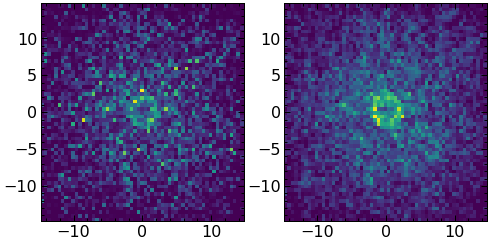

In [1299]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].pcolormesh(xv, yv, kerma_hist[:,:,0])
ax[1].pcolormesh(xv, yv, dose_hist[:,:,0])

In [1300]:
z = binsz[1:] -np.diff(binsz)/2
kerma_center = np.mean(kerma_hist[28:33,28:33,:], axis=(0,1))
dose_center = np.mean(dose_hist[28:33,28:33,:], axis=(0,1))
#kerma_center = kerma_hist[30,30,:]
#dose_center = dose_hist[30,30,:]

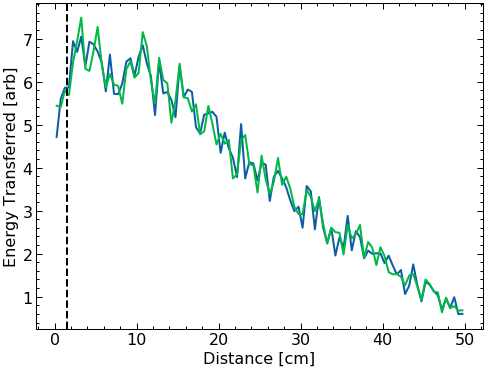

In [1301]:
plt.plot(z, kerma_center)
plt.plot(z, dose_center)
plt.axvline(1.5, color='k', ls='--')
plt.xlabel('Distance [cm]')
plt.ylabel('Energy Transferred [arb]')
plt.show()

How to get electrons to dose

In [472]:
E_init

array([0.01865184, 0.02283298, 0.02552254, ..., 1.7494569 , 0.2494569 ,
       0.2494569 ])

In [481]:
X_init = r.X_e
E_init = r.E_e
E_final = 10e-3
dEdx = 2
phi, theta = r.Ang_e[0], r.Ang_e[1]
n = np.array([np.cos(phi)*np.sin(theta), np.sin(phi)*np.sin(theta), np.cos(theta)])
E_deposited = E_init-E_final
X_final = X_init + n * (1/dEdx)* E_deposited
d_travelled = 1/(dEdx) * (E_init - E_final)

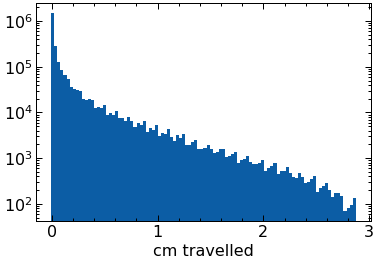

In [482]:
plt.hist(d_travelled, bins=100)
plt.semilogy()
plt.xlabel('cm travelled')
plt.show()

In [497]:
n = 50
points = np.linspace(0,1,n)
binsx = np.arange(-15,15,0.5)
binsy = np.arange(-15,15,0.5)
binsz = np.arange(0,50,0.5)
E_hist = np.zeros((len(binsx)-1, len(binsy)-1, len(binsz)-1))

In [498]:
for p in points:
    X = X_init + p*(1/dEdx)*E_deposited * n
    E_hist += np.histogramdd(X.T, [binsx, binsy, binsz],
                          weights=r.E_e/n)[0]

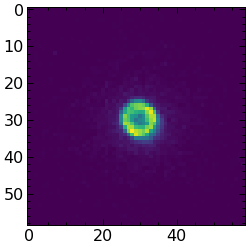

In [505]:
plt.imshow(E_hist[:,:,4])

### Testing 2

ISOTROPIC FROM POINT SOURCE

In [580]:
N = 100000
E = get_6MV_spectrum(N)
X = np.zeros((3,N))
Phi0 = 2*np.pi*uniform(size=N)
Theta0 = np.arccos(1-2*uniform(size=N))
Ang = np.array([Phi0, Theta0])
Ebins = 10.0**(np.linspace(-3,2, 100))
int_types = np.arange(4)
r = RadSim(E, X, Ang, Ebins, int_types, XYZ_lim=[10000,10000,-10000,50000])

In [581]:
while True:
    if r.iterate():
        break

In [582]:
int_total_per_energy = r.IntHist_p.sum(axis=0)
a1, a2, a3, a4 = r.IntHist_p / int_total_per_energy 

/Users/lukepolson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


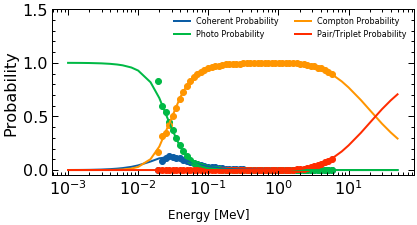

In [583]:
fig, ax = plt.subplots(1, 1, figsize=(6,3))
ax.plot(energy_d, coherent_d/mu_d, label=r'Coherent Probability')
ax.plot(energy_d, photo_d/mu_d, label=r'Photo Probability')
ax.plot(energy_d, compton_d/mu_d, label=r'Compton Probability')
ax.plot(energy_d, pairtrip_d/mu_d, label=r'Pair/Triplet Probability')
ax.semilogx()
ax.legend(fontsize=8, ncol=2)
ax.set_ylim(top=1.5)
ax.set_ylabel('Probability')
fig.suptitle('Energy [MeV]', y=0)
fig.tight_layout()
plt.scatter(Ebins[0:-1] + np.diff(Ebins)/2, a1)
plt.scatter(Ebins[0:-1] + np.diff(Ebins)/2, a2)
plt.scatter(Ebins[0:-1] + np.diff(Ebins)/2, a3)
plt.scatter(Ebins[0:-1] + np.diff(Ebins)/2, a4)

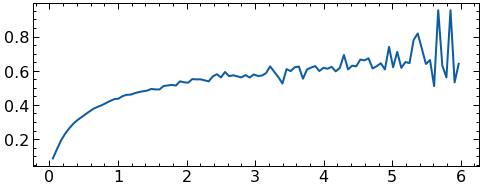

In [584]:
counts, b, c= np.histogram2d(r.comptonratios, r.comptonenergies, bins=100)
counts/=counts.sum(axis=0)
ee_arr = b[:-1] + np.diff(b)/2
ep_arr = c[:-1] + np.diff(c)/2
ee_avg_arr = counts.T@ee_arr
plt.figure(figsize=(8,3))
plt.plot(ep_arr, ee_avg_arr)

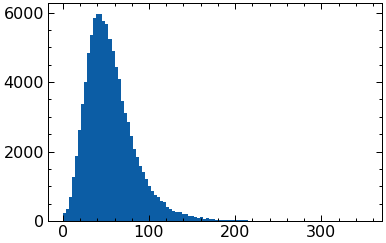

In [585]:
rad = np.sqrt(r.X_p[0]**2 + r.X_p[1]**2 + r.X_p[2]**2)
plt.hist(rad, bins=100)
plt.show()

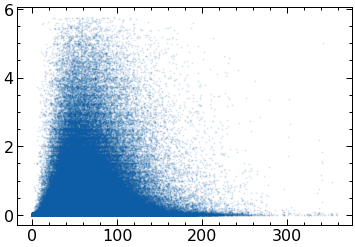

In [592]:
plt.scatter(rad, r.E_e, s=1, alpha=0.1)

`X_e` and `E_e` are also useful as energy transffered statsa

Energy transerred vs, distance from point source

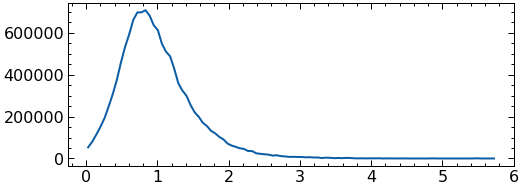

In [586]:
rad = np.sqrt(r.X_e[0]**2 + r.X_e[1]**2 + r.X_e[2]**2)
counts, b, c= np.histogram2d(r.E_e, rad, bins=100)
rad_arr = b[:-1] + np.diff(b)/2
E_arr = c[:-1] + np.diff(c)/2
E_avg_arr = counts.T@E_arr
plt.figure(figsize=(8,3))
plt.plot(rad_arr, E_avg_arr)

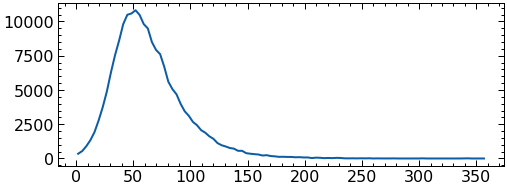

In [587]:
rad = np.sqrt(r.X_e[0]**2 + r.X_e[1]**2 + r.X_e[2]**2)
energy, bins = np.histogram(rad, bins=100, weights=r.E_e)
rad_arr = bins[:-1] + np.diff(bins)/2
plt.figure(figsize=(8,3))
plt.plot(rad_arr, energy)

### Testing 1: histogram of interactions

In [141]:
N = 100000
E = np.ones(N)*0.02
X = np.zeros((3,N))
Phi0 = 2*np.pi*uniform(size=N)
Theta0 = np.arccos(1-2*uniform(size=N))
Ang = np.array([Phi0, Theta0])
Ebins = 10.0**(np.linspace(-3,2, 100))
int_types = np.arange(4)
r = RadSim(E, X, Ang, Ebins, int_types)

In [142]:
r.update_position()
r.get_inttype()

In [147]:
int_total_per_energy = r.IntHist_p.sum(axis=0)
a1, a2, a3, a4 = r.IntHist_p / int_total_per_energy 

/Users/lukepolson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


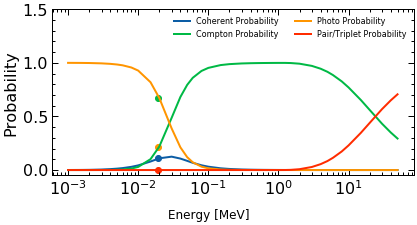

In [154]:
fig, ax = plt.subplots(1, 1, figsize=(6,3))
ax.plot(energy_d, coherent_d/mu_d, label=r'Coherent Probability')
ax.plot(energy_d, compton_d/mu_d, label=r'Compton Probability')
ax.plot(energy_d, photo_d/mu_d, label=r'Photo Probability')
ax.plot(energy_d, pairtrip_d/mu_d, label=r'Pair/Triplet Probability')
ax.semilogx()
ax.legend(fontsize=8, ncol=2)
ax.set_ylim(top=1.5)
ax.set_ylabel('Probability')
fig.suptitle('Energy [MeV]', y=0)
fig.tight_layout()
plt.scatter(Ebins[0:-1] + np.diff(Ebins)/2, a1)
plt.scatter(Ebins[0:-1] + np.diff(Ebins)/2, a2)
plt.scatter(Ebins[0:-1] + np.diff(Ebins)/2, a3)
plt.scatter(Ebins[0:-1] + np.diff(Ebins)/2, a4)

In [135]:
r.X_p

array([[-0.08348864,  0.24811656,  2.4274012 , ...,  0.02921945,
        -0.03323792,  0.24344362],
       [-1.07006682, -0.53515427,  0.5315242 , ..., -0.04947443,
         0.24340444, -0.09739573],
       [-0.54814335, -0.45837849, -2.19410307, ...,  0.06285835,
        -0.10084799,  0.16870045]])

In [116]:
[a for a in range(10)]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [110]:
Ebins = 10.0**(np.linspace(-3,2, 100))
IntHist = np.zeros((len(Ebins)-1, 4))

In [111]:
E = 20 + 10*np.random.uniform(size=1000)
I = get_interaction_type(E)

In [112]:
Ebins.shape

(100,)

In [114]:
np.histogram(E[I==4], Ebins)[0].shape

(99,)

In [90]:
I

array([4, 3, 4, 4, 3, 3, 4, 3, 4, 4, 3, 4, 4, 3, 4, 3, 4, 4, 3, 4, 4, 3,
       4, 4, 3, 4, 4, 4, 4, 3, 3, 4, 3, 4, 3, 3, 3, 3, 4, 3, 4, 3, 4, 3,
       4, 3, 4, 4, 3, 3, 3, 4, 3, 3, 4, 3, 3, 3, 4, 4, 3, 4, 3, 4, 4, 4,
       3, 4, 4, 3, 4, 4, 3, 4, 3, 4, 4, 3, 4, 4, 4, 4, 3, 4, 3, 4, 4, 3,
       4, 4, 3, 3, 3, 4, 3, 3, 3, 3, 4, 3, 3, 4, 3, 4, 3, 3, 3, 4, 4, 3,
       4, 3, 3, 4, 4, 4, 3, 3, 3, 3, 3, 4, 3, 3, 4, 3, 4, 4, 4, 4, 4, 3,
       3, 3, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 4, 3, 3, 4, 3, 3,
       3, 3, 3, 4, 4, 4, 3, 4, 3, 4, 4, 3, 4, 4, 4, 3, 3, 3, 4, 3, 3, 3,
       4, 3, 4, 3, 4, 4, 4, 4, 3, 3, 4, 3, 4, 4, 3, 3, 4, 3, 4, 4, 3, 3,
       4, 4, 3, 4, 3, 4, 4, 3, 4, 4, 4, 4, 3, 4, 4, 4, 3, 3, 3, 4, 4, 4,
       4, 4, 3, 3, 3, 4, 3, 4, 4, 3, 4, 3, 3, 3, 4, 4, 4, 3, 4, 4, 4, 3,
       4, 3, 4, 4, 4, 4, 4, 3, 3, 3, 4, 4, 4, 4, 4, 3, 3, 4, 3, 4, 3, 3,
       3, 4, 4, 3, 3, 4, 4, 4, 3, 3, 3, 4, 3, 3, 3, 3, 4, 3, 3, 3, 4, 4,
       3, 4, 3, 3, 3, 3, 4, 3, 4, 3, 4, 4, 4, 4, 3,

In [64]:
y = RadSim()
y.call()

0


In [ ]:
def run_compton_iterations(N, E_val, E_cutoff, m=0.511):
    # Get initial decay angles of all photons
    Phi0 = 2*np.pi*uniform(size=N)
    Theta0 = np.arccos(1-2*uniform(size=N))
    n0 = np.array([np.cos(Phi0)*np.sin(Theta0),
              np.sin(Phi0)*np.sin(Theta0),
              np.cos(Theta0)])
    # Get initial energy, length before decay, and position of all photons
    E = np.ones(N) * E_val #energy
    L = -1/mu_f(E) *np.log(uniform(size=N))
    r = L * n0 
    M = np.ones(N).astype(bool) 
    iteration = 0
    iterations = []
    interactions = []
    # For compton scattering statistics
    all_energies_photon_comp = []
    all_energies_electron_comp = []
    while True:
        # Throughout this, M gives indices of particles that haven't decayed yet, I is interaction type
        iterations.append(iteration)
        interactions.append(sum(M))
        I = get_interaction_type(E[M])
        '''Coherent Scatter'''
        i = M * (I==1)
        M1 = True #all photons still going (this case, all of them)
        '''Photoelectric Effect'''
        i = M * (I==2)
        M2 = !(I==2) #all photons still going (this case, none of them)
        '''Compton Scatter'''
        i = M * (I==3)
        Theta_new_p = klein.get_rvs(E[i]) 
        Phi_new_p = 2*np.pi*uniform(size=len(E[i]))
        # Get electron energy from new angles
        T = E[i] - E[i] / (1 + E[i]/m * (1-np.cos(Theta_new_p)))
        all_energies_photon_comp.append(E[i].copy())
        all_energies_electron_comp.append(T.copy()/E[i].copy())
        # Now change the energies
        E[i] = E[i] / (1 + E[i]/m * (1-np.cos(Theta_new_p)))
        L = -1/mu_f(E[i]) *np.log(uniform(size=len(E[i])))
        n = np.squeeze(get_new_units(Theta0[i], Phi0[i], Theta_new_p, Phi_new_p), axis=1)
        # New Directions
        Phi0 = np.arctan(n[1]/n[0])
        Theta0 = np.arctan(np.sqrt(n[0]**2+n[1]**2)/n[2])
        # only consider these points now
        E = E[M]
        M = E>E_cutoff
        iteration +=1
        if np.all(~M):
            return (np.array(iterations), np.array(interactions),
                   np.concatenate(all_energies_photon_comp),
                   np.concatenate(all_energies_electron_comp))